In [1]:
import pandas as pd
from nilearn import image, plotting, masking
from scipy import ndimage 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/Users/gilles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ref = image.load_img('/data/odc/derivatives/spynoza/sub-tk/ses-odc2/func/sub-tk_ses-odc2_task-checkerboard_acq-07_run-02_bold_reference.nii.gz')

In [3]:
zmap = image.load_img('/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_left_over_right_zmap.nii.gz')

layers_left = image.load_img('/data/odc/derivatives/nighres/layers/sub-tk_left_cruise_gwb_layering_depth.nii.gz')
layers_right = image.load_img('/data/odc/derivatives/nighres/layers/sub-tk_right_cruise_gwb_layering_depth.nii.gz')
layers = image.math_img('layers_l + layers_r', layers_l=layers_left, layers_r=layers_right)

In [4]:
layers_bold = image.resample_to_img(layers, zmap, interpolation='nearest')
layers_bold.to_filename('/data/odc/zooi/depth_bold.nii.gz')

In [5]:
image.resample_to_img('/data/odc/zooi/V1.rh.nii.gz', zmap, 'nearest').to_filename('/data/odc/zooi/V1.rh.bold.nii.gz')
image.resample_to_img('/data/odc/zooi/V1.lh.nii.gz', zmap, 'nearest').to_filename('/data/odc/zooi/V1.lh.bold.nii.gz')

v1 = image.math_img('v1_lh + v1_rh', v1_lh='/data/odc/zooi/V1.lh.bold.nii.gz', v1_rh='/data/odc/zooi/V1.rh.bold.nii.gz')

v1 = image.new_img_like(zmap, ndimage.binary_dilation(v1.get_data(), iterations=2))
mask = image.math_img('(v1 > 0) & (depth > 0) & (np.abs(zmap) > 1.)', v1=v1, depth=layers_bold, zmap=zmap)

In [33]:
import glob
import re
reg = re.compile('.*/sub-tk_ses-odc2_run-(?P<run>[0-9\.]+)_(?P<stimulation>[a-z]+)_psc.nii.gz')

right = glob.glob('/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-*0_right_psc.nii.gz')
left = glob.glob('/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-*0_left_psc.nii.gz')
psc = left + right

df = []
depth_map = masking.apply_mask(layers_bold, mask)
z = masking.apply_mask(zmap, mask)

for fn in psc:
    print(fn)
    d = reg.match(fn).groupdict()
    d['task'] = int(float(d['run'])) % 2
    d['psc'] = masking.apply_mask(fn, mask)
    d['depth'] = depth_map
    d['z'] = z
    d['run'] = int(float(d['run']))
    
    tmp = pd.DataFrame(d)
    tmp.index.set_names('voxel', inplace=True)
    tmp.reset_index(inplace=True)
    
    df.append(tmp)
    
df = pd.concat(df)

/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-1.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-10.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-2.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-3.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-4.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-5.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-6.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-7.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-8.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7/sub-tk/ses-odc2/sub-tk_ses-odc2_run-9.0_left_psc.nii.gz
/data/odc/derivatives/modelfitting/glm7

In [34]:

n_layers = 5
df['layer'] = pd.cut(df.depth, n_layers, labels=np.arange(1, n_layers+1))
df['ODC type'] = df['z'].map(lambda z: 'left' if z > 0 else 'right')
df['task'] = df.task.map({0:'checkerboard', 1:'fixation'})

In [39]:
tmp = df.pivot_table(columns=['stimulation', 'voxel'], index='run', values='psc')

contrast = tmp['left'] - tmp['right']

In [46]:
import scipy as sp

In [47]:
sp.stats.pearsonr(contrast.loc[:5].mean(), contrast.loc[5:].mean())

(0.6915500334180674, 0.0)

In [202]:
import numpy as np

In [203]:
sns.set_style('whitegrid')

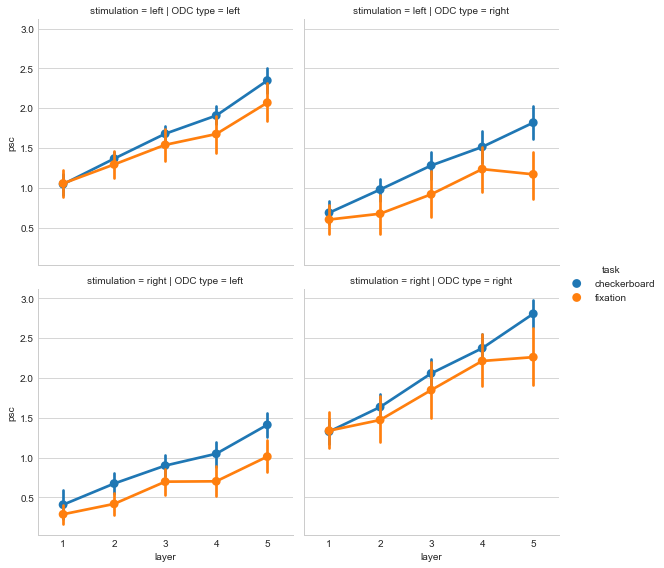

In [204]:
sns.factorplot('layer', 'psc', 'task', df, units='run', col='ODC type', row='stimulation', ci=67, col_order=['left', 'right'], row_order=['left', 'right'])
plt.savefig('/Users/gilles/Downloads/laminae.pdf')

In [205]:
df['input'] = df['ODC type'] == df['stimulation']

In [ ]:
df.sort_values('')

In [207]:
tmp = df.pivot_table(index=['layer', 'voxel'], columns=['stimulation', 'task'], values=['psc'], aggfunc=np.mean)['psc']
tmp = tmp['left'] - tmp['right']
# sns.factorplot('layer', 'value', 'input', data=tmp.reset_index().melt(id_vars='layer'))

In [208]:
tmp['left_sensitive'] = (tmp['checkerboard'] > 0) | (tmp['fixation'] > 0)


In [209]:
tmp = tmp.reset_index('layer').melt(id_vars=['layer', 'left_sensitive'])
tmp['value'] = tmp['value'].abs()

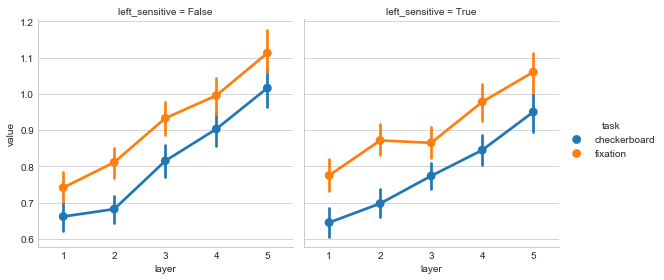

In [210]:
sns.factorplot('layer', 'value', 'task', tmp, col='left_sensitive')

/Users/gilles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


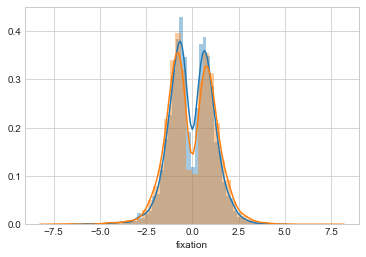

In [165]:
sns.distplot(tmp['checkerboard'])
sns.distplot(tmp['fixation'])

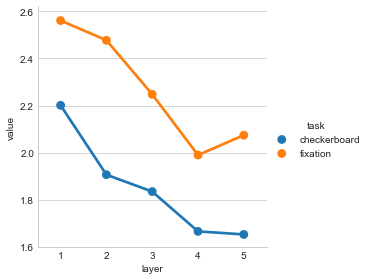

In [136]:
tmp = df.pivot_table(index=['layer'], columns=['input', 'task'], values=['psc'], aggfunc=np.mean)['psc']
tmp = tmp[True] / tmp[False]
sns.factorplot('layer', 'value', 'task', data=tmp.reset_index().melt(id_vars='layer'))

In [114]:
tmp = df.pivot_table(index=['voxel', 'layer'], columns=['task', 'input'], values=['psc'], aggfunc=np.median)['psc']
tmp.head()
#((tmp['checkerboard'] / tmp['fixation']) / (tmp['checkerboard'] + tmp['fixation']))

task        checkerboard            fixation          
input              False     True      False     True 
voxel layer                                           
0     5         1.906708  2.317249  2.775714  3.458436
1     4         0.984016  2.784421  1.650603  2.420311
2     3        -0.464876 -0.026428  0.082211  0.393310
3     2         0.861183  1.495827 -0.627657  0.079116
4     2         0.992919  1.982612 -0.646794  0.344993

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


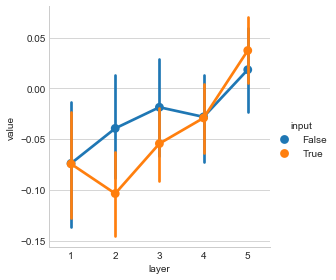

In [111]:
tmp = df.pivot_table(index=['voxel', 'layer'], columns=['task', 'input'], values=['psc'], aggfunc=np.median)['psc']
tmp = (np.log(tmp['checkerboard'] / tmp['fixation'])).reset_index('layer').melt(id_vars='layer')

# tmp = tmp[np.abs(tmp) < 100]

sns.factorplot('layer', 'value', 'input', data=tmp, ci=67)

In [99]:
tmp.mean()

task          input
checkerboard  False    1.239862
              True     2.176558
fixation      False    0.905480
              True     1.995771
dtype: float64

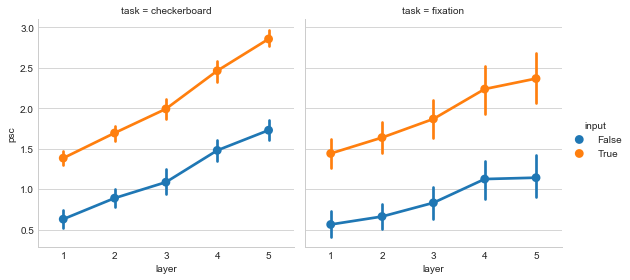

In [116]:
sns.factorplot('layer', 'psc', 'input', df, units='run', col='task', ci=67)

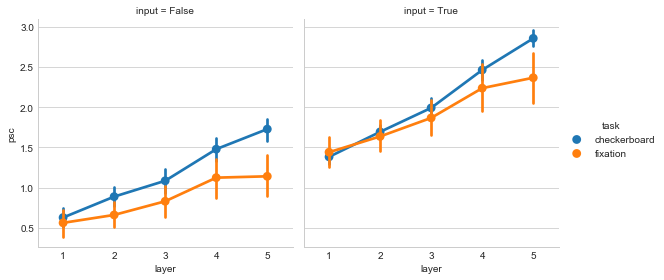

In [117]:
sns.factorplot('layer', 'psc', 'task', df, col='input', units='run', ci=67)
plt.savefig('/Users/gilles/Downloads/laminae_stim.pdf')

In [137]:
import sklearn

In [138]:
from sklearn.model_selection import KFold

In [150]:
runs = np.arange(1, 11)

models = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

kf = KFold(n_splits=5)
for train, test in kf.split(models):
    print(train)

[2 3 4 5 6 7]
[0 1 4 5 6 7]
[0 1 2 3 6 7]
[0 1 2 3 4 5 7]
[0 1 2 3 4 5 6]


In [152]:
[1,2,3,4][[1, 2]]

TypeError: list indices must be integers or slices, not list

In [143]:
10 // 2

5